# Classification of cardiomyocites based on their action potentials
In this lab experience we will be looking at the problem of classifying cardiac cells by looking at
their _Action Potentials_ (APs). For the purpose of this task we will be using synthetically
generated APs following the models in [(Nygren et. al, 1998)](https://www.ahajournals.org/doi/abs/10.1161/01.res.82.1.63) and [(O'Hara et. al, 2011)](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1002061).

### Objectives
By the end of this session you should be able to use nearest-neighbor and simple neural network classifiers for two-class classification problems.

* _Note: Everything below this line should be truned in as part of your lab report._


In [24]:
# ============================================================================
# import modules
# ============================================================================
# Note that this part of the code needs to be run prior to any other code cell

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import random as rnd
import torch
import numpy as np

# Global variables 
FIGSIZE = (14,10)
pointsize = 8


# inline plots
%matplotlib inline

# set random number generator seed
rnd.seed(10)

# mount GDrive
from google.colab import drive
drive.mount('gdrive/')

# ============================================================================
# data loading
# ============================================================================

# PLEASE, SPECIFY YOUR PATH TO THE DATA HERE
datapath = 'gdrive/My Drive/bmdslab/lab-02/'

# get the list of files to process
matfile = '/'.join((datapath,'Adult_samples.mat'))

# get data as dictionary
adata = scipy.io.loadmat(matfile)

# see the keys of the dictionary 'Vatrial' and 'Vventricular'
# adata['Vatrial'] contains action potentials of cardiac cells of atrial type
# adata['Vventricular'] contains action potentials of cardiac cells of ventricular type
adata.keys()



Drive already mounted at gdrive/; to attempt to forcibly remount, call drive.mount("gdrive/", force_remount=True).


dict_keys(['__header__', '__version__', '__globals__', 'Vatrial', 'Vventricular'])

Text(0.5, 0, 'sample')

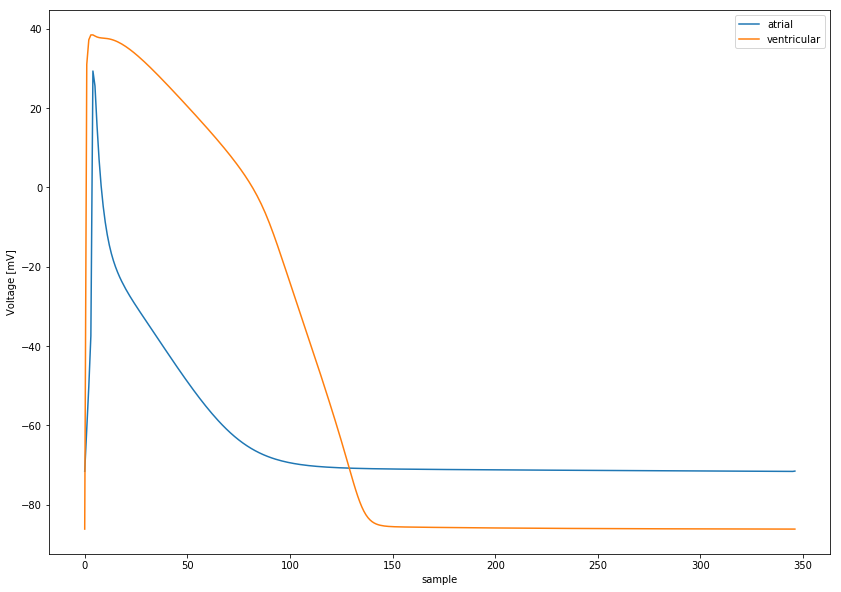

In [25]:
# look at the data dimensions
adata['Vatrial'].shape

# let's see how the data looks like
plt.figure(figsize = FIGSIZE)
plt.plot(adata['Vatrial'][:,0])
plt.plot(adata['Vventricular'][:,0])
plt.legend(('atrial','ventricular'))
plt.ylabel('Voltage [mV]')
plt.xlabel('sample')

### Task 1. Pre-processing and manual feature extraction
In this first part we will be normalizing the data and extracting hand-crafted features that will be later
used for the classification task. Load the dataset **Adult_samples.mat** that contains examples of
adult atrial and ventricular action potentials generated using the models in [(Nygren et al., 1998)](https://www.ahajournals.org/doi/abs/10.1161/01.res.82.1.63) and [(O'Hara et al., 2011)](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1002061).
For each of the two classes there are $1000$ samples generated with a sampling rate of $f_s=500$ Hz.

* _(15 points) Data preparation and normalization._
Split the data between test and training sets by
randomly selecting $10\%$ of the points as your training set. Make sure the two classes are well represented
in the training set (e.g., use the same number for both). Normalize the data so that each AP has zero resting potential and unit maximum amplitude. Create an array of corresponding labels for the data points. For ventricular type use the class label $+1$ and $-1$ for
atrial type.
Make two plots displaying your normalized training data for each of the classes. Use time units for the horizontal axis.

Text(0.5, 1.0, 'Ventricular cell action potential')

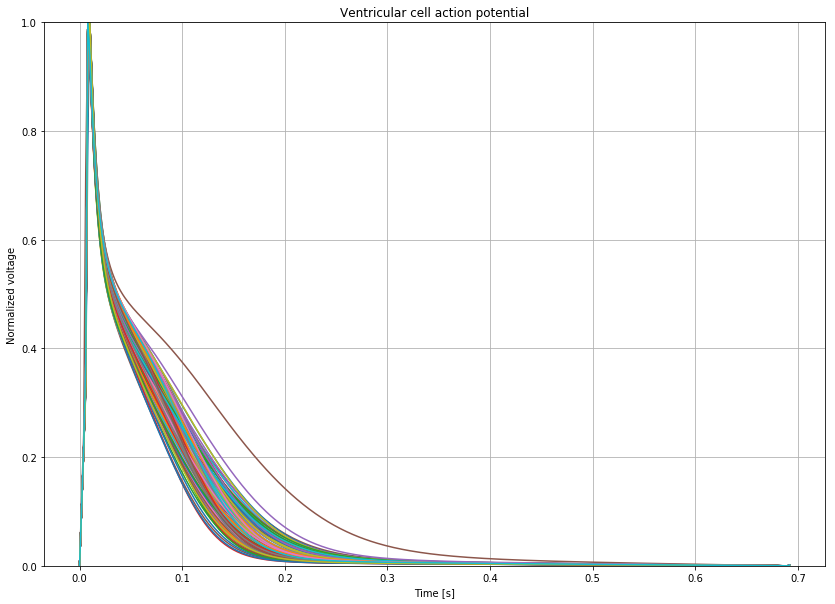

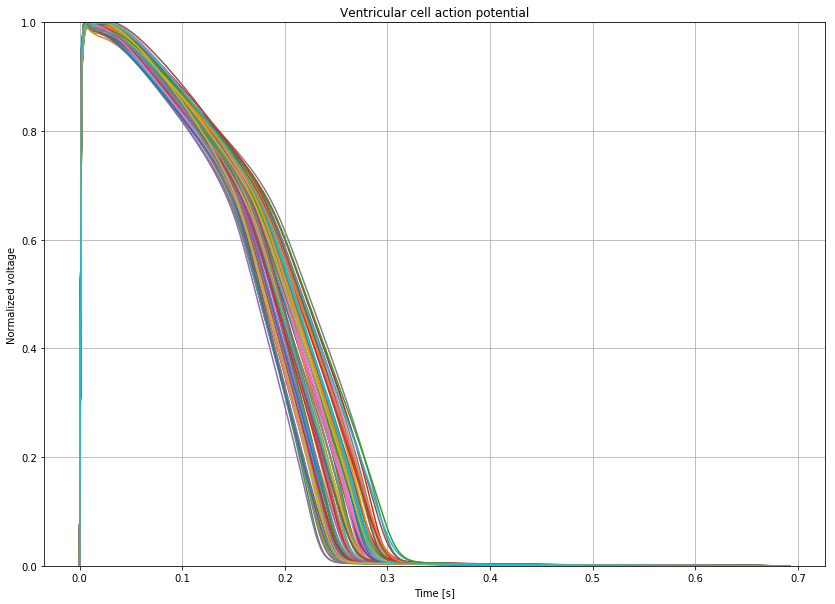

In [26]:
testFraction = .1
N = adata['Vatrial'].shape[1]
length = adata['Vatrial'].shape[0]
sampling_frequency = 500 
time_axis = np.linspace(0, (length-1)/sampling_frequency, length)

sample = np.ones(N, dtype=bool)
sample[:int(testFraction*N)] = False  
np.random.shuffle(sample)

N_train = sum(sample)
N_test = N - N_train


## Deameaning, normalizing and plotting vatrial action potentials
trainData_vatrial = adata['Vatrial'][:, sample]
testData_vatrial = adata['Vatrial'][:, ~sample]

for i in range(N_train):
  trainData_vatrial[:,i] -= np.min(trainData_vatrial[:,i])
  trainData_vatrial[:,i] /= np.max(trainData_vatrial[:,i])
for i in range(N_test):
  testData_vatrial[:,i] -= np.min(testData_vatrial[:,i])
  testData_vatrial[:,i] /= np.max(testData_vatrial[:,i])

  
plt.figure(figsize = FIGSIZE) 
plt.plot(time_axis, testData_vatrial)
plt.grid()
plt.ylim((0,1))
plt.xlabel('Time [s]')
plt.ylabel('Normalized voltage')
plt.title('Ventricular cell action potential')


## Deameaning, normalizing and plotting ventricular action potentials
trainData_ventricular = adata['Vventricular'][:, sample]
testData_ventricular = adata['Vventricular'][:, ~sample]


for i in range(N_train):
  trainData_ventricular[:,i] -= np.min(trainData_ventricular[:,i])
  trainData_ventricular[:,i] /= np.max(trainData_ventricular[:,i])
for i in range(N_test):
  testData_ventricular[:,i] -= np.min(testData_ventricular[:,i])
  testData_ventricular[:,i] /= np.max(testData_ventricular[:,i])

  
plt.figure(figsize = FIGSIZE) 
plt.plot(time_axis, testData_ventricular)
plt.grid()
plt.ylim((0,1))
plt.xlabel('Time [s]')
plt.ylabel('Normalized voltage')
plt.title('Ventricular cell action potential')


In [0]:
# Create X vectors and Y vectors
X_train = np.zeros((length, 2*N_train))
X_train[:,:int(N_train)] = trainData_vatrial
X_train[:,int(N_train):] = trainData_ventricular

X_test = np.zeros((length, 2*N_test))
X_test[:,:int(N_test)] = testData_vatrial
X_test[:,int(N_test):] = testData_ventricular

Y_train = np.ones((2*N_train,1))
Y_train[int(N_train):] = -1*Y_train[int(N_train):]

Y_test = np.ones((2*N_test,1))
Y_test[int(N_test):] = -1*Y_test[int(N_test):]


* _(20 points) Hand-crafted features._
The _Action Potential Duration_ (APD) at $x\%$ is defined as the time
it takes to reduce the maximum amplitude of the AP to $x\%$ of its value. Write a function that computes APD at a given
percentage $x\in[0,1]$. Compute also the _Average of the Action Potential_ (AAP) and build two-dimensional features
by concatenating APD@$0.5$ and AAP. Make a scatter plot of the training data using these two features. Use
different colors and/or markers to represent each class.

    * Based on your scatter plot, is the training data using the above features linearly separable? Why?

Text(0, 0.5, 'Action Potential Duration at 50.0%')

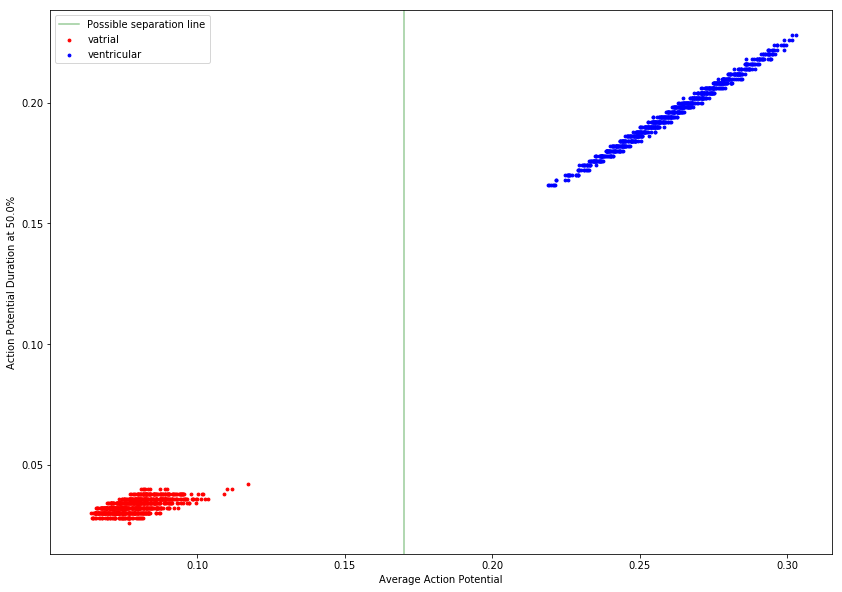

In [28]:
# ============================================================================
# compute hand-crafted features such as APA and APDx
# ============================================================================

def apdx(X,alpha=0.5,fs=1.0):
    """
    This function computes the APDx feature defined as the time it takes to
    reduce the action potential to x% of its maximum value.
    Use:
        APD = apdx(X,alpha,fs)
        
    Inputs:
        X : data points (each column is a data point)
        alpha : [0,1] percentage of maximum amplitude
        fs : sampling frequency (to map samples to time)
        
    Output:
        APD feature
    """

    # write your function code here
    reached_max = False 
    maximum_value = np.max(X) # Here, the data points are normalized to have a 
    # max of 1, but I decided to keep it general 
    i = 0
    for point in X: 
      if point == maximum_value: 
        reached_max = True
      if reached_max: 
        if point < alpha: 
          return i/fs
      i += 1


def aap(X): 
  return np.mean(X)

potential_threshold = 0.5


AAP_train = np.zeros(2*N_train)
for i in range(len(AAP_train)):
  AAP_train[i] = aap(X_train[:,i])
  
AAP_test = np.zeros(2*N_test)
for i in range(len(AAP_test)): 
  AAP_test[i] = aap(X_test[:,i])

APD_train = np.zeros(2*N_train)
for i in range(len(APD_train)):
  APD_train[i] = apdx(X_train[:,i], potential_threshold, sampling_frequency)
  
APD_test = np.zeros(2*N_test)
for i in range(len(APD_test)): 
  APD_test[i] = apdx(X_test[:,i], potential_threshold, sampling_frequency)
  
plt.figure(figsize = FIGSIZE)
plt.scatter(AAP_train[:int(N_train)], APD_train[:int(N_train)], color = 'r', s = pointsize)
plt.scatter(AAP_train[int(N_train):], APD_train[int(N_train):], color = 'b', s = pointsize)
plt.axvline(x=np.mean(AAP_train), color = 'g', alpha=0.4)

plt.legend(['Possible separation line', 'vatrial', 'ventricular'])
plt.xlabel('Average Action Potential')
plt.ylabel('Action Potential Duration at ' + str(100*potential_threshold) + "%")

#Observation 
The two types of cells can definitely be classified using these parameters. The two features are linearly separable (meaning they can be separated with a single line).

### Task 2. Classification

* _(15 points) Nearest-neighbor classifier._
Implement a $1$NN classifier using the Euclidean distance. A $1$NN classifier works as follows: Given your training dataset $\mathcal{D} = \big\{(\boldsymbol x_i,y_i)\big\}_{i=1}^{N}$,where $N$ is the number of training samples, $\boldsymbol x_i\in\mathbb{R}^D$ is a feature vector and $y_i\in\{-1,1\}$ its associated label, and a novel sample $\boldsymbol x$, the $1$NN classifier assigns to $\boldsymbol x$ the same label as its closest point in the training set. That is, the estimated label $\widehat y$ of $\boldsymbol x$ is such that:

\begin{equation}
	\widehat y(\boldsymbol x) = y_{k^*},\quad k^* = \underset{i\in\{1,\ldots,N\}}{\arg\min}\, \lVert \boldsymbol x_i - \boldsymbol x \rVert_2.
\end{equation}

Compute and display the classification accuracy over the test set using the handcrafted training features of **Task 1**.

In [29]:
# ============================================================================
# Nearest-neighbor classifier
# ============================================================================

def nn_classify(Xtest,Xtrain,Ytrain):
    """
    This function implements a nearest neighbor classifier.
    Use:
        yhat = nn_classify(Xtest,Xtrain,ytrain)
        
    Inputs:
        Xtest  : test data points (each column is a data point)
        Xtrain : training data points
        ytrain : associated labels to the training data points
        
    Output:
        yhat : estimated labels for the test data.

    """
    
    # implement your NN classifier below
    # Compute features for all sets 
    Ntest = Xtest.shape[1]
    Ntrain = Xtrain.shape[1]
    
    AAPtrain = np.zeros(Ntrain)
    for i in range(len(AAPtrain)):
      AAPtrain[i] = aap(Xtrain[:,i])
  
    AAPtest = np.zeros(Ntest)
    for i in range(len(AAPtest)): 
      AAPtest[i] = aap(Xtest[:,i])

    APDtrain = np.zeros(Ntrain)
    for i in range(len(APDtrain)):
      APDtrain[i] = apdx(Xtrain[:,i], potential_threshold, sampling_frequency)
  
    APDtest = np.zeros(Ntest)
    for i in range(len(APDtest)): 
      APDtest[i] = apdx(Xtest[:,i], potential_threshold, sampling_frequency)
    
    predictions = np.zeros(Ntest)
    for i in range(Ntest): 
      distances = np.zeros(Ntrain)
      x1 = np.array([AAPtest[i], APDtest[i]])
      for j in range(Ntrain): 
        x2 = np.array([AAPtrain[j], APDtrain[j]])
        distances[j] = np.linalg.norm(x1-x2)
      index_nn = np.argmin(distances)
      predictions[i] = Ytrain[index_nn]
      
    return predictions
pred = nn_classify(X_test, X_train, Y_train)

correct = 0
for i in range(N_test): 
  if (pred[i] == Y_test[i]): 
    correct += 1
accuracy = correct/N_test*100


print('Accuracy is ' + str(round(accuracy, 2)) + '%')

Accuracy is 100.0%


* _(40 points) Two-layer Neural Network._
 Implement a two-layer neural network classifier of the form:

   $$\widehat y = \operatorname{sign}\big(f_{\theta}(\phi(\boldsymbol x))\big),\quad f_{\theta}(\phi(\boldsymbol x)) = \boldsymbol w^T\phi(\boldsymbol x) + b,\quad \theta = \left[\begin{array}{c}\boldsymbol w\\b\end{array}\right],$$
  
 where $f_\theta(\cdot)$ is a _linear prediction function_ (i.e., classification layer) parametrized by $\theta = [\boldsymbol w^T, b]^T$. The feature extraction part of the network consists of a linear layer followed by a ReLu (rectified linear unit) non-linearity:
 
 $$ \phi(x) = \operatorname{ReLu}\big(\boldsymbol W_1 \boldsymbol x + \boldsymbol b_1\big),\quad\operatorname{ReLu}(x)=\begin{cases}x &x>0\\0&\textrm{else}\end{cases}.$$
 
 In order to find the network's parameters $\Theta=\{\boldsymbol W_1, \boldsymbol b_1, \boldsymbol w, b\}$ minimize the following _regularized empirical risk_ using PyTorch:

   $$\min_{\Theta}\, \underbrace{\frac{1}{N} \sum_{i=1}^N L\big(f_\theta(\phi(\boldsymbol x_i)),y_i\big) + \lambda\big(\frac{1}{w}\lVert \boldsymbol w\rVert^2 + \frac{1}{W}\lVert\boldsymbol W_1\rVert^2\big)}_{C(\Theta)}$$
    
 where the loss function $L(f, y) = \lVert y-f\rVert_2^2)$ is the quadratic (square) loss, and $w,W$, are the number of elements in $\boldsymbol w$ and $\boldsymbol W$, respectively. 

    * Define a network model in PyTorch according to the definition above. For that purpose you can use `torch.nn.Sequential`. Follow this [example](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#pytorch-nn) to learn how to use it.
    
    * Run a gradient descent algorithm to minimize the cost function using $\lambda =1$. Carefully choose the stepsize and number of iterations until you see the method converges (i.e., the cost function gets to a "plateau").
    
    * Make a scatter plot of the learned features (i.e., prior to classificaiton layer) by your network model. Has your model learned features that are linearly separable? Display in the scatter plot the decision boundary that you have learned. Compute the classification accuracy over the test set.
    
    * Plot the weights of the learned linear layer. What has your network learned?

**1)**

In [0]:
import torch 
torch.manual_seed(0)

dtype = torch.float
device = torch.device("cpu") 

generation = True
learning_rate = 1e-2
tol = 1e-9
gen_max = 1e9
lambda_ = 1
N_features = 2



# Convert x to tensor
x = torch.from_numpy(np.transpose(X_train)).float()
x_test = torch.from_numpy(np.transpose(X_test)).float()
y = torch.from_numpy(Y_train).float()
y_test = torch.from_numpy(Y_train).float()

loss_fn = torch.nn.MSELoss(reduction='mean')

W = torch.nn.Linear(len(x[0]), N_features, bias = True)
R = torch.nn.ReLU()
w = torch.nn.Linear(N_features, 1, bias = True)

model = torch.nn.Sequential(
    W, 
    R,
    w
)

**2)**

It took 5314 generations to reach a tolerance of 1e-09.


Text(0.5, 1.0, 'Loss function evaluation over the generations')

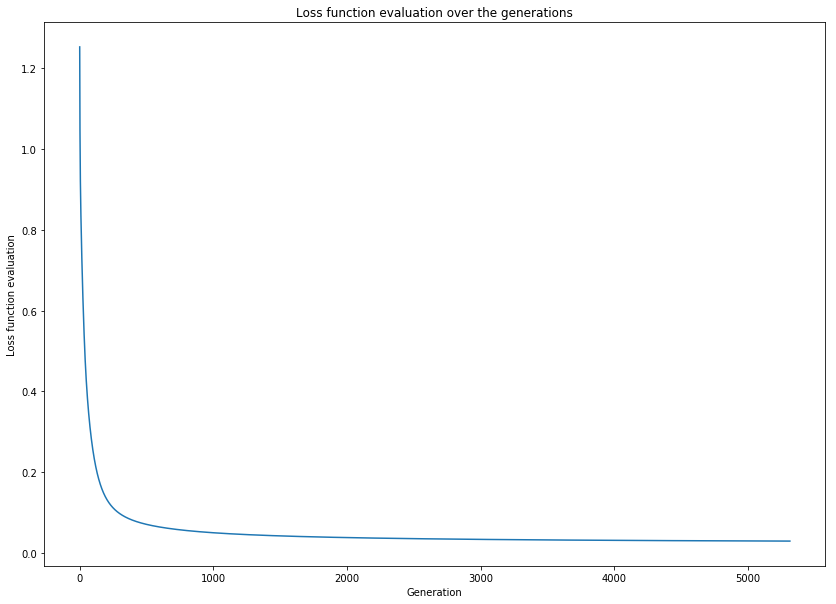

In [31]:
gen = 0

loss_list = []
while(generation and gen<gen_max):
  y_pred = model(x)
  loss = loss_fn(y_pred, y) + lambda_*(w.weight.pow(2).mean() + W.weight.pow(2).mean())
  model.zero_grad()
  loss.backward()
  
  loss_list.append(loss.item())
  if (gen>1): 
    generation = ((loss_list[-2] - loss_list[-1]) > tol)
  gen += 1
     
  with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad
          
if (not generation): 
  print("It took " + str(gen) + " generations to reach a tolerance of " + str(tol) + ".")
else: 
  print("Iteration stopped after " + str(gen_max) + " iterations, " + str(tol) + " tolerance not reached.")
plt.figure(figsize = FIGSIZE)
plt.plot(loss_list)
plt.xlabel('Generation')
plt.ylabel('Loss function evaluation')
plt.title('Loss function evaluation over the generations')



Accuracy is 100.0%


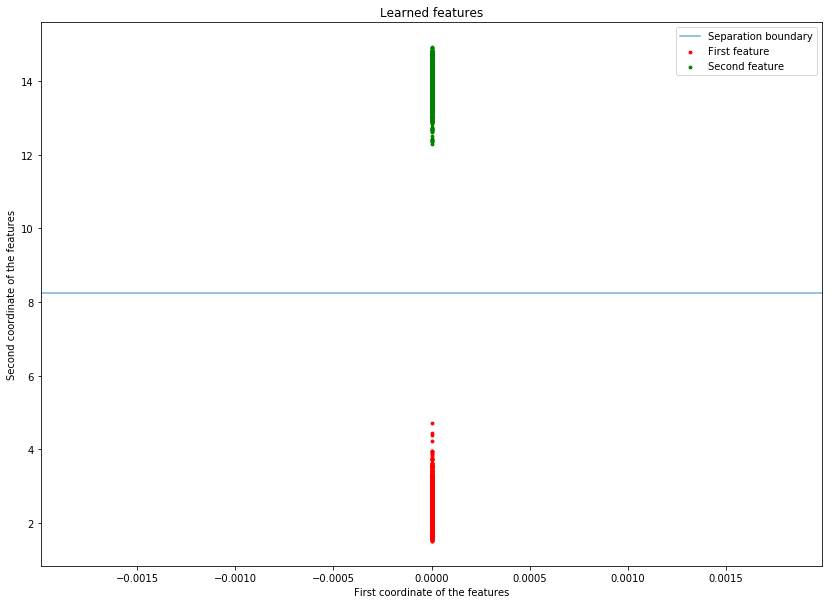

In [32]:
features = R(W(x))
plt.figure(figsize = FIGSIZE)
plt.scatter(features.detach().numpy()[:N_train,0], features.detach().numpy()[:N_train,1], color = 'r', s = pointsize)
plt.scatter(features.detach().numpy()[N_train:,0], features.detach().numpy()[N_train:,1], color = 'g', s = pointsize)
plt.axhline(y=np.mean(features.detach().numpy()[:,1]), alpha = 0.6)
plt.legend(['Separation boundary', 'First feature', 'Second feature'])
plt.xlabel('First coordinate of the features')
plt.ylabel('Second coordinate of the features')
plt.title('Learned features')


prediction = np.sign(model(x_test).detach().numpy())
correct = 0
for i in range(len(prediction)): 
  if (prediction[i] == Y_test[i]): 
    correct += 1
accuracy = correct/len(pred)*100
print('Accuracy is ' + str(round(accuracy, 2)) + '%')

Yes, the model has learned features that are linearly separable. It is possible to separate the features using a straight line. 

**4)**

Text(0.5, 1.0, 'Weights of the learned linear layer')

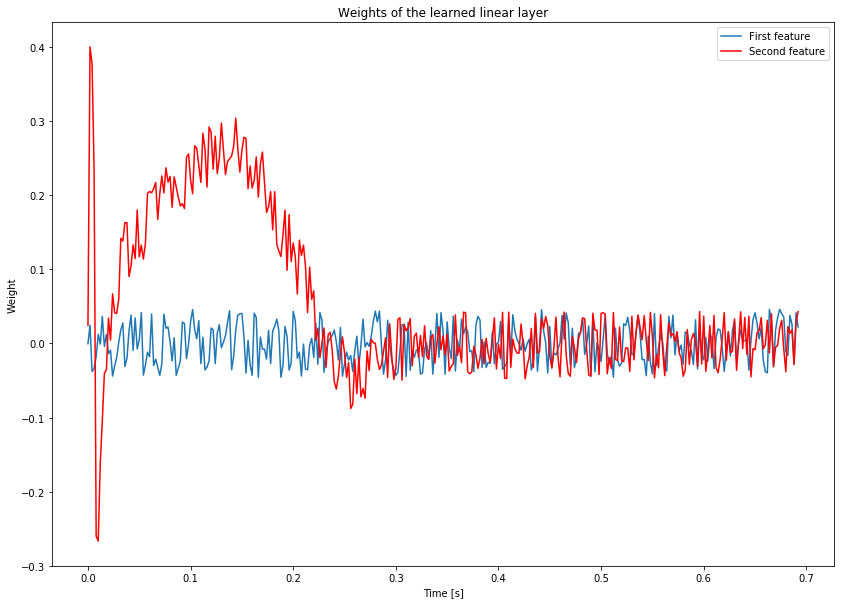

In [33]:
weight = W.weight
plt.figure(figsize = FIGSIZE)
plt.plot(time_axis, weight.detach().numpy()[0,:])
plt.plot(time_axis, weight.detach().numpy()[1,:], color = 'r')
plt.xlabel('Time [s]')
plt.ylabel('Weight')
plt.legend(['First feature', 'Second feature'])
plt.title('Weights of the learned linear layer')


The model has learned that to identify a ventricular cell action potential, it is sufficient to look at the very first data points (because the action potential rises faster), and after about 0.15s, because it also drops more slowly. Remember ventricular is +1, so the weights are positive where a behavior is the data points are expected to be higher for a ventricular action potential. 
The model has learned to recognize which type of cell an action potential corresponds to similarly to how a human would describe it. 